# Turn aggregated data into weekly-behavior data

In [81]:
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_selection import RFE
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    confusion_matrix, average_precision_score, roc_auc_score,
    precision_recall_curve)
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier

## Transform Zoom dataset

In [2]:
zoom = pd.read_excel(r"C:\Users\Admin\Documents\Studio Code\customer_retention_data\student-dropout-analysis\data_processed\final_zoom.xlsx", dtype={'SID':str})
zoom

,Topic,ID,Host name,Host email,Start time,End time,Participants,Duration (minutes),Name (original name),Email,...,Grade,SID_full,Name,EFL,Note,MVA/MVSM,concat,4 last digits,Học sinh cùng lớp có chung 4 số cuối ID,_merge
0,2501HUM,977 3083 0512,schedule 1,schedule1@minhvietacademy.org,9/30/2024 19:25,9/30/2024 20:25,211,60,Mai Nguyen Truc Linh 01816,23001816@minhvietacademy.org,...,Grade 1,2300-1816,Mai Nguyễn Trúc Linh,EFL K5,Chính thức,MVA,MVA2300-1816,1816.0,NaN,both
1,2501HUM,977 3083 0512,schedule 1,schedule1@minhvietacademy.org,9/30/2024 19:25,9/30/2024 20:25,211,60,Nguyen Pham Nhat Minh 02469,22002469@minhvietacademy.org,...,Grade 1,2200-2469,Nguyễn Phạm Nhật Minh,EFL K5,Chính thức,MVA,MVA2200-2469,2469.0,NaN,both
2,2501HUM,977 3083 0512,schedule 1,schedule1@minhvietacademy.org,9/30/2024 19:25,9/30/2024 20:25,211,60,Yen Ha Tu Vy 02190,24002190@minhvietacademy.org,...,Grade 1,2400-2190,VY HÀ TÚ YÊN,EFL K5,Chính thức,MVA,MVA2400-2190,2190.0,NaN,both
3,2501HUM,977 3083 0512,schedule 1,schedule1@minhvietacademy.org,9/30/2024 19:25,9/30/2024 20:25,211,60,Lai Ngan Khanh 01771,23001771@minhvietacademy.org,...,Grade 1,2300-1771,Lại Ngân Khánh,EFL K5,Chính thức,MVA,MVA2300-1771,1771.0,NaN,both
4,2501HUM,977 3083 0512,schedule 1,schedule1@minhvietacademy.org,9/30/2024 19:25,9/30/2024 20:25,211,60,Tran Minh Khang 03927,23003927@minhvietacademy.org,...,Grade 1,2300-3927,Trần Minh Khang,EFL K5,Chính thức,MVA,MVA2300-3927,3927.0,NaN,both
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
271177,25APBIO,942 5158 6913,Schedule 9,schedule9@minhvietacademy.org,5/5/2025 19:25,5/5/2025 20:23,47,58,"Nguyen Hung, Viet",NaN,...,Grade 9-12,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,left_only
271178,25APBIO,942 5158 6913,Schedule 9,schedule9@minhvietacademy.org,5/5/2025 19:25,5/5/2025 20:23,47,58,"Than Thu, Nguyen Minh",NaN,...,Grade 9-12,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,left_only
271179,25APBIO,942 5158 6913,Schedule 9,schedule9@minhvietacademy.org,5/5/2025 19:25,5/5/2025 20:23,47,58,"Nguyen Tien, Anh",NaN,...,Grade 9-12,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,left_only
271180,25APENG,996 9559 8473,Schedule 9,schedule9@minhvietacademy.org,5/5/2025 18:24,5/5/2025 19:25,40,61,phạm nguyên phúc hưng 02068,NaN,...,Grade 9-12,2400-2068,Phạm Nguyên Phúc Hưng,EFL 69,Chính thức,MVA,MVA2400-2068,2068.0,NaN,both


#### Aggregrate disconnected sessions
As students sometimes have internet issues and got disconnected from zoom, their participation is splitted into smaller sessions/records that seem like disengagement. So here we group them back together

In [3]:
#zoom events (ze)
ze = zoom.copy()

ze['Start time'] = pd.to_datetime(ze['Start time'], errors='coerce')
ze['End time'] = pd.to_datetime(ze['End time'], errors='coerce')
ze['Join time'] = pd.to_datetime(ze['Join time'], errors='coerce')
ze['Leave time'] = pd.to_datetime(ze['Leave time'], errors='coerce')


ze = (ze.groupby(['SID', 'Topic', 'Start time'])
              .agg(
                  end_time=('End time', 'max'),
                  student_duration=('student_stay_duration', 'sum'),
                  join_time=('Join time', 'min'),
                  leave_time=('Leave time', 'max'),
                  grade=('Grade', 'last'),
                  duration=('Duration (minutes)', 'first')
              )).reset_index()

ze['date'] = ze['Start time'].dt.floor("D")

ze

,SID,Topic,Start time,end_time,student_duration,join_time,leave_time,grade,duration,date
0,00000006,2506ELA,2025-02-24 18:24:00,2025-02-24 19:26:00,61,2025-02-24 18:24:00,2025-02-24 19:24:00,Grade 6,63,2025-02-24
1,00000006,2506ELA,2025-02-26 18:25:00,2025-02-26 19:26:00,45,2025-02-26 18:42:00,2025-02-26 19:26:00,Grade 6,62,2025-02-26
2,00000006,2506ELA,2025-03-03 18:26:00,2025-03-03 19:26:00,60,2025-03-03 18:27:00,2025-03-03 19:26:00,Grade 6,61,2025-03-03
3,00000006,2506ELA,2025-03-05 18:25:00,2025-03-05 19:27:00,9,2025-03-05 19:16:00,2025-03-05 19:25:00,Grade 6,63,2025-03-05
4,00000006,2506ELA,2025-03-17 18:27:00,2025-03-17 19:26:00,59,2025-03-17 18:27:00,2025-03-17 19:26:00,Grade 6,60,2025-03-17
...,...,...,...,...,...,...,...,...,...,...
207563,25000506,2501HUM,2025-05-27 19:25:00,2025-05-27 20:25:00,30,2025-05-27 19:55:00,2025-05-27 20:25:00,Grade 1,60,2025-05-27
207564,25000506,2501HUM,2025-05-29 19:27:00,2025-05-29 20:25:00,55,2025-05-29 19:30:00,2025-05-29 20:25:00,Grade 1,59,2025-05-29
207565,25000506,2501MAT,2025-05-14 19:26:00,2025-05-14 20:24:00,58,2025-05-14 19:26:00,2025-05-14 20:24:00,Grade 1,58,2025-05-14
207566,25000506,2501MAT,2025-05-21 19:26:00,2025-05-21 20:28:00,60,2025-05-21 19:28:00,2025-05-21 20:28:00,Grade 1,62,2025-05-21


#### Compute Minutes late / Minutes leaving early / Absent flag

In [4]:
grace_min = 5 #the school allows for 5 minutes grace

ze['minutes_late'] = ((ze['join_time'] - ze['Start time']).dt.total_seconds()/60) - grace_min
ze['minutes_late'] = ze['minutes_late'].clip(lower=0)

ze['minutes_left_early'] = ((ze['end_time'] - ze['leave_time']).dt.total_seconds()/60)
ze['minutes_left_early'] = ze['minutes_left_early'].clip(lower=0)

ze['attended_ratio'] = (ze['student_duration']/ze['duration'])
ze['very_short_flag'] = (ze['student_duration']<15).astype(int)
ze['partial_present'] = (ze['attended_ratio'] < 0.75).astype(int)
ze['is_present'] = (ze['attended_ratio']>0.25).astype(int)

ze.head()

,SID,Topic,Start time,end_time,student_duration,join_time,leave_time,grade,duration,date,minutes_late,minutes_left_early,attended_ratio,very_short_flag,partial_present,is_present
0,00000006,2506ELA,2025-02-24 18:24:00,2025-02-24 19:26:00,61,2025-02-24 18:24:00,2025-02-24 19:24:00,Grade 6,63,2025-02-24,0.0,2.0,0.968254,0,0,1
1,00000006,2506ELA,2025-02-26 18:25:00,2025-02-26 19:26:00,45,2025-02-26 18:42:00,2025-02-26 19:26:00,Grade 6,62,2025-02-26,12.0,0.0,0.725806,0,1,1
2,00000006,2506ELA,2025-03-03 18:26:00,2025-03-03 19:26:00,60,2025-03-03 18:27:00,2025-03-03 19:26:00,Grade 6,61,2025-03-03,0.0,0.0,0.983607,0,0,1
3,00000006,2506ELA,2025-03-05 18:25:00,2025-03-05 19:27:00,9,2025-03-05 19:16:00,2025-03-05 19:25:00,Grade 6,63,2025-03-05,46.0,2.0,0.142857,1,1,0
4,00000006,2506ELA,2025-03-17 18:27:00,2025-03-17 19:26:00,59,2025-03-17 18:27:00,2025-03-17 19:26:00,Grade 6,60,2025-03-17,0.0,0.0,0.983333,0,0,1


#### Aggregrate to day-level
As students can have multiple sessions per day, here we aggregrate to form the basis for week-level

In [5]:
day = (ze.groupby(['SID', 'date'])
       .agg(
           late_max=('minutes_late', 'max'), #max minutes late in that day
           late_mean=('minutes_late', 'mean'), #mean minutes late (over all the sessions in that day)
           late_sum=('minutes_late', 'sum'), #total minutes late in that day
           early_max=('minutes_left_early', 'max'), #max minutes left_early in that day
           early_mean=('minutes_left_early', 'mean'),#mean minutes left early (over all the sessions in that day)
           early_sum=('minutes_left_early', 'sum'), #total minutes left early in that day
           very_short_any=('very_short_flag', 'max'), #if there is 1 session attended under 15 minutes in that day or not 
           very_short_mean=('very_short_flag', 'mean'), #mean sessions atteneded under 15 minutes in that day
           very_short_sum=('very_short_flag', 'sum'), #total sessions atteneded under 15 minutes in that day
           partial_any=('partial_present', 'max'), #if there is 1 partially attended in that day or not 
           partial_mean=('partial_present', 'mean'), #mean sessions partially atteneded in that day
           partial_sum=('partial_present', 'sum'), #total sessions partially atteneded in that day
           attended_ratio_mean=('attended_ratio', 'mean'), #mean attended rate in that day
           attended_ratio_min=('attended_ratio', 'min'), #lowest attended rate in that day
           minutes_attended_day=('student_duration', 'sum'), #total minutes joined in that day
           total_duration_day=('duration', 'sum'), #total scheduled minutes of classes in that day
           is_present_day=('is_present', 'max')
       )).reset_index()

day['attended_ratio'] = day['minutes_attended_day']/day['total_duration_day'].replace(0,np.nan)
day.head()

,SID,date,late_max,late_mean,late_sum,early_max,early_mean,early_sum,very_short_any,very_short_mean,very_short_sum,partial_any,partial_mean,partial_sum,attended_ratio_mean,attended_ratio_min,minutes_attended_day,total_duration_day,is_present_day,attended_ratio
0,00000006,2025-02-20,0.0,0.0,0.0,14.0,7.0,14.0,0,0.0,0,1,0.5,1,0.872881,0.745763,106,121,1,0.876033
1,00000006,2025-02-24,0.0,0.0,0.0,11.0,6.5,13.0,0,0.0,0,0,0.0,0,0.885766,0.803279,110,124,1,0.887097
2,00000006,2025-02-25,3.0,1.5,3.0,7.0,4.5,9.0,0,0.0,0,0,0.0,0,0.860656,0.836066,105,122,1,0.860656
3,00000006,2025-02-26,12.0,6.0,12.0,17.0,8.5,17.0,0,0.0,0,1,1.0,2,0.707166,0.688525,87,123,1,0.707317
4,00000006,2025-02-27,0.0,0.0,0.0,20.0,20.0,20.0,0,0.0,0,1,1.0,1,0.590164,0.590164,36,61,1,0.590164


#### Convert day -> week statistics

In [6]:
to_week = lambda d:d.to_period("W-SUN").start_time
day['week_start'] = day['date'].map(to_week)

weekly_stats = (day.groupby(['SID', 'week_start'])
                .agg(
                    #Alert signs
                    late_max=('late_max', 'max'),
                    early_max=('late_max', 'max'),
                    total_late_minutes=('late_sum', 'sum'),
                    total_early_minutes=('early_sum', 'sum'),

                    #Trend
                    late_mean=('late_mean', 'mean'),
                    early_mean=('early_mean', 'mean'),
                    attended_ratio_mean=('attended_ratio_mean', 'mean'),
                    attended_ratio_week=('attended_ratio', 'mean'),


                    #Count the very short/partially-attend sessions
                    very_short_any=('very_short_any', 'max'),
                    total_very_short=('very_short_sum', 'sum'),
                    partial_any=('partial_any', 'max'),
                    total_partial=('partial_sum', 'sum'),

                    #others
                    days_present_w=('is_present_day', 'sum'),
                    days_observed_w=('date', 'nunique'),

                    #general info
                    total_attended_minutes_w=('minutes_attended_day', 'sum'),
                    total_planned_minutes_w=('total_duration_day', 'sum')

                )
                ).reset_index()

weekly_stats

,SID,week_start,late_max,early_max,total_late_minutes,total_early_minutes,late_mean,early_mean,attended_ratio_mean,attended_ratio_week,very_short_any,total_very_short,partial_any,total_partial,days_present_w,days_observed_w,total_attended_minutes_w,total_planned_minutes_w
0,00000006,2025-02-17,0.0,0.0,0.0,14.0,0.000000,7.000,0.872881,0.876033,0,0,1,1,1,1,106,121
1,00000006,2025-02-24,12.0,12.0,15.0,59.0,1.875000,9.875,0.760938,0.761308,0,0,1,3,4,4,338,430
2,00000006,2025-03-03,46.0,46.0,87.0,139.0,10.875000,17.375,0.492652,0.491510,1,3,1,6,3,4,241,489
3,00000006,2025-03-10,0.0,0.0,0.0,26.0,0.000000,13.000,0.778552,0.776860,0,0,1,1,1,1,94,121
4,00000006,2025-03-17,0.0,0.0,0.0,72.0,0.000000,9.000,0.833031,0.834568,0,0,1,3,4,4,404,484
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
46134,25000396,2025-05-12,2.0,2.0,2.0,0.0,0.500000,0.000,0.942281,0.942281,0,0,0,0,4,4,228,242
46135,25000396,2025-05-19,0.0,0.0,0.0,0.0,0.000000,0.000,0.970968,0.970968,0,0,0,0,4,4,235,242
46136,25000506,2025-05-12,13.0,13.0,13.0,0.0,3.250000,0.000,0.919492,0.919492,0,0,1,1,4,4,214,233
46137,25000506,2025-05-19,6.0,6.0,9.0,0.0,2.250000,0.000,0.907190,0.907190,0,0,0,0,4,4,217,239


#### Fill in the missing weeks of each student

In [7]:
def fill_missing_weeks(weekly_df, sid_col="SID", week_col="week_start"):
    out=[]
    
    for sid, g in weekly_df.groupby(sid_col, sort=False):
        g = g.sort_values(week_col)
        if g.empty:
            continue
        
        start = g[week_col].min()
        end = g[week_col].max()

        full_weeks = pd.date_range(start, end, freq="W-MON")

        have = pd.DatetimeIndex(g[week_col])
        missing = full_weeks.difference(have)

        if len(missing):
            add = pd.DataFrame({sid_col: sid, week_col: pd.to_datetime(missing)})
            g=pd.concat([g,add], ignore_index=True, sort=False)

        out.append(g)

    res = pd.concat(out, ignore_index=True)
    res = res.sort_values([sid_col, week_col]).reset_index(drop=True)
    return res

In [8]:
weekly_stats1 = fill_missing_weeks(weekly_stats, sid_col="SID", week_col="week_start")

count_cols = ['days_present_w', 'days_observed_w', 'total_attended_minutes_w', 'total_planned_minutes_w']
for c in count_cols:
    if c in count_cols:
        weekly_stats1[c] = weekly_stats1[c].fillna(0).astype(int)

weekly_stats1

#weekly_stats1.to_csv('filled_weeks.csv', index=False)

,SID,week_start,late_max,early_max,total_late_minutes,total_early_minutes,late_mean,early_mean,attended_ratio_mean,attended_ratio_week,very_short_any,total_very_short,partial_any,total_partial,days_present_w,days_observed_w,total_attended_minutes_w,total_planned_minutes_w
0,00000006,2025-02-17,0.0,0.0,0.0,14.0,0.000000,7.000,0.872881,0.876033,0.0,0.0,1.0,1.0,1,1,106,121
1,00000006,2025-02-24,12.0,12.0,15.0,59.0,1.875000,9.875,0.760938,0.761308,0.0,0.0,1.0,3.0,4,4,338,430
2,00000006,2025-03-03,46.0,46.0,87.0,139.0,10.875000,17.375,0.492652,0.491510,1.0,3.0,1.0,6.0,3,4,241,489
3,00000006,2025-03-10,0.0,0.0,0.0,26.0,0.000000,13.000,0.778552,0.776860,0.0,0.0,1.0,1.0,1,1,94,121
4,00000006,2025-03-17,0.0,0.0,0.0,72.0,0.000000,9.000,0.833031,0.834568,0.0,0.0,1.0,3.0,4,4,404,484
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
53427,25000396,2025-05-12,2.0,2.0,2.0,0.0,0.500000,0.000,0.942281,0.942281,0.0,0.0,0.0,0.0,4,4,228,242
53428,25000396,2025-05-19,0.0,0.0,0.0,0.0,0.000000,0.000,0.970968,0.970968,0.0,0.0,0.0,0.0,4,4,235,242
53429,25000506,2025-05-12,13.0,13.0,13.0,0.0,3.250000,0.000,0.919492,0.919492,0.0,0.0,1.0,1.0,4,4,214,233
53430,25000506,2025-05-19,6.0,6.0,9.0,0.0,2.250000,0.000,0.907190,0.907190,0.0,0.0,0.0,0.0,4,4,217,239


## Transform Engagement Dataset

In [9]:
engage = pd.read_excel(r"C:\Users\Admin\Documents\Studio Code\customer_retention_data\student-dropout-analysis\data_processed\final_goiten.xlsx", dtype={'SID':str})
engage

,SID_full,SID,SID_5digit,Name,Grade,Call,percent_response,success_call,no_resp_calls,Successful,No_response
0,1904-0019,19040019,40019,Hoàng Gia An,Grade 9,0,0.0,0,0,NaN,NaN
1,1904-0019,19040019,40019,Hoàng Gia An,EFL 69,0,0.0,0,0,NaN,NaN
2,1904-0020,19040020,40020,Hoàng Khải Lâm,Grade 9,0,0.0,0,0,NaN,NaN
3,1904-0020,19040020,40020,Hoàng Khải Lâm,EFL 69,0,0.0,0,0,NaN,NaN
4,1904-0024,19040024,40024,Lê Hà Thu,Grade 9,0,0.0,0,0,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...
4431,2500-0268,25000268,268,Han Bao Nguyen,Grade 4,0,0.0,0,0,NaN,NaN
4432,2500-0288,25000288,288,Thanh Nguyen,Grade K,0,0.0,0,0,NaN,NaN
4433,2500-0319,25000319,319,Khang Duy Doan,Grade 2,0,0.0,0,0,NaN,NaN
4434,2500-0331,25000331,331,Hy Nghien Hua,Grade 1,0,0.0,0,0,NaN,NaN


In [10]:
engagement = engage.copy() 

def parse_dd_mm_list_to_weeks(s, start_year=2024):
    if pd.isna(s) or str(s).strip()=="":
        return []
    parts = [p.strip() for p in str(s).split(",") if p.strip()]
    dts = pd.to_datetime(parts, format="%d/%m", errors="coerce", dayfirst=True)
    out = []
    for dt in dts:
        if pd.isna(dt): 
            continue
        m = int(dt.month)
        y = start_year if 6 <= m <= 12 else start_year + 1
        d = pd.Timestamp(year=y, month=int(dt.month), day=int(dt.day))
        out.append(pd.Period(d, freq="W-SUN").start_time)
    return out

rows = []
for sid, s in engagement[["SID", "Successful"]].itertuples(index=False):
    for ws in parse_dd_mm_list_to_weeks(s):
        rows.append((sid, ws))

if rows:
    called_counts = (pd.DataFrame(rows, columns=["SID", "week_start"])
                     .value_counts()
                     .rename("called_count_w")
                     .reset_index())
else:
    called_counts = pd.DataFrame(columns=["SID", "week_start", "called_count_w"])


called_counts

,SID,week_start,called_count_w
0,24001070,2024-12-09,6
1,24001070,2024-10-28,6
2,20023177,2024-08-19,6
3,22002271,2024-06-24,6
4,20037981,2025-02-24,6
...,...,...,...
11363,22002046,2025-05-05,1
11364,22002046,2025-05-19,1
11365,22002047,2024-06-03,1
11366,22002047,2024-09-16,1


In [11]:
rows = []
for sid, s in engagement[["SID", "No_response"]].itertuples(index=False):
    for ws in parse_dd_mm_list_to_weeks(s):
        rows.append((sid, ws))

if rows:
    called_failed_counts = (pd.DataFrame(rows, columns=["SID", "week_start"])
                     .value_counts()
                     .rename("called_failed_w")
                     .reset_index())
else:
    called_failed_counts = pd.DataFrame(columns=["SID", "week_start", "called_failed_w"])


called_failed_counts

,SID,week_start,called_failed_w
0,24001456,2024-11-04,3
1,24001293,2024-10-07,3
2,24001827,2024-10-14,2
3,22000288,2024-08-12,2
4,22003235,2024-07-15,2
...,...,...,...
802,22003683,2024-10-21,1
803,22003683,2024-11-25,1
804,22003707,2025-05-19,1
805,22003890,2024-06-03,1


In [12]:
weekly_stats_all = (weekly_stats1
                .merge(called_counts, on=["SID","week_start"], how="left")
                .merge(called_failed_counts, on=['SID', 'week_start'], how='left'))

# Weeks with no engagement → 0 calls
weekly_stats_all["called_count_w"] = weekly_stats_all["called_count_w"].fillna(0).astype(int)
weekly_stats_all["called_failed_w"] = weekly_stats_all["called_failed_w"].fillna(0).astype(int)



weekly_stats_all

,SID,week_start,late_max,early_max,total_late_minutes,total_early_minutes,late_mean,early_mean,attended_ratio_mean,attended_ratio_week,very_short_any,total_very_short,partial_any,total_partial,days_present_w,days_observed_w,total_attended_minutes_w,total_planned_minutes_w,called_count_w,called_failed_w
0,00000006,2025-02-17,0.0,0.0,0.0,14.0,0.000000,7.000,0.872881,0.876033,0.0,0.0,1.0,1.0,1,1,106,121,0,0
1,00000006,2025-02-24,12.0,12.0,15.0,59.0,1.875000,9.875,0.760938,0.761308,0.0,0.0,1.0,3.0,4,4,338,430,0,0
2,00000006,2025-03-03,46.0,46.0,87.0,139.0,10.875000,17.375,0.492652,0.491510,1.0,3.0,1.0,6.0,3,4,241,489,0,0
3,00000006,2025-03-10,0.0,0.0,0.0,26.0,0.000000,13.000,0.778552,0.776860,0.0,0.0,1.0,1.0,1,1,94,121,0,0
4,00000006,2025-03-17,0.0,0.0,0.0,72.0,0.000000,9.000,0.833031,0.834568,0.0,0.0,1.0,3.0,4,4,404,484,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
53427,25000396,2025-05-12,2.0,2.0,2.0,0.0,0.500000,0.000,0.942281,0.942281,0.0,0.0,0.0,0.0,4,4,228,242,0,0
53428,25000396,2025-05-19,0.0,0.0,0.0,0.0,0.000000,0.000,0.970968,0.970968,0.0,0.0,0.0,0.0,4,4,235,242,0,0
53429,25000506,2025-05-12,13.0,13.0,13.0,0.0,3.250000,0.000,0.919492,0.919492,0.0,0.0,1.0,1.0,4,4,214,233,0,0
53430,25000506,2025-05-19,6.0,6.0,9.0,0.0,2.250000,0.000,0.907190,0.907190,0.0,0.0,0.0,0.0,4,4,217,239,0,0


In [13]:
weekly_stats_all.to_csv('weekly_stats_all.csv', index=False)

## Add Quiz Data

In [14]:
canvas = pd.read_excel(r"C:\Users\Admin\Documents\Studio Code\customer_retention_data\student-dropout-analysis\data_processed\final_canvas.xlsx", dtype={'SID': str})
canvas

,ID,SID,Student,Section,Quiz,Score,Source_File,Quiz_Clean
0,613,19040019,Hoàng Gia An - 19040019,AP Biology F2024,AP BIO ch1 (79507),21.00,2025-09-06T0350_Grades-AP_Biology_F2024,AP BIO ch1
1,613,19040019,Hoàng Gia An - 19040019,AP Biology F2024,AP BIO ch10 (79508),16.00,2025-09-06T0350_Grades-AP_Biology_F2024,AP BIO ch10
2,613,19040019,Hoàng Gia An - 19040019,AP Biology F2024,AP BIO ch11 (79509),17.00,2025-09-06T0350_Grades-AP_Biology_F2024,AP BIO ch11
3,613,19040019,Hoàng Gia An - 19040019,AP Biology F2024,AP BIO ch12 (79506),18.00,2025-09-06T0350_Grades-AP_Biology_F2024,AP BIO ch12
4,613,19040019,Hoàng Gia An - 19040019,AP Biology F2024,AP BIO ch13 (79505),16.00,2025-09-06T0350_Grades-AP_Biology_F2024,AP BIO ch13
...,...,...,...,...,...,...,...,...
394874,12104,22002539,Sophie - 22002539,Grade 3 Math F2024,Unposted Current Score,90.00,2025-09-06T0353_Grades-Grade_3_Math_F2024,Unposted Current Score
394875,12104,22002539,Sophie - 22002539,Grade 2 Humanities F2024,Unposted Final Score,34.89,2025-09-06T0351_Grades-Grade_2_Humanities_F2024,Unposted Final Score
394876,12104,22002539,Sophie - 22002539,Grade 2 Math F2024,Unposted Final Score,21.05,2025-09-06T0352_Grades-Grade_2_Math_F2024,Unposted Final Score
394877,12104,22002539,Sophie - 22002539,Grade 3 Humanities F2024,Unposted Final Score,0.00,2025-09-06T0353_Grades-Grade_3_Humanities_F2024,Unposted Final Score


In [15]:
#Check the quiz scores and their possible values
out = canvas.groupby('Quiz_Clean')['Score'].agg(
    n_rows='size',
    n_no_null='count'
)

out['no_nan_pct'] = out['n_no_null']/out['n_rows']
out = out.sort_values(by='no_nan_pct')
out

,n_rows,n_no_null,no_nan_pct
Quiz_Clean,,,
�Exam Unposted Final Score,99,0,0.0
Migrated Quizzes Current Score,210,0,0.0
Math Vocabulary Review,203,0,0.0
Instructions and Practice - no grade Unposted Final Score,178,0,0.0
BrainPOP Unposted Final Score,168,0,0.0
...,...,...,...
Exam Final Points,168,168,1.0
Exam Current Points,168,168,1.0
Essays Unposted Final Score,315,315,1.0


In [16]:
#Remove the quizzes that have 0 students doing - potentially an optional quiz
mask_keep = canvas.groupby('Quiz_Clean')['Score'].transform(lambda s:s.notna().any())
canvas_filtered = canvas[mask_keep].copy()
canvas_filtered

,ID,SID,Student,Section,Quiz,Score,Source_File,Quiz_Clean
0,613,19040019,Hoàng Gia An - 19040019,AP Biology F2024,AP BIO ch1 (79507),21.00,2025-09-06T0350_Grades-AP_Biology_F2024,AP BIO ch1
1,613,19040019,Hoàng Gia An - 19040019,AP Biology F2024,AP BIO ch10 (79508),16.00,2025-09-06T0350_Grades-AP_Biology_F2024,AP BIO ch10
2,613,19040019,Hoàng Gia An - 19040019,AP Biology F2024,AP BIO ch11 (79509),17.00,2025-09-06T0350_Grades-AP_Biology_F2024,AP BIO ch11
3,613,19040019,Hoàng Gia An - 19040019,AP Biology F2024,AP BIO ch12 (79506),18.00,2025-09-06T0350_Grades-AP_Biology_F2024,AP BIO ch12
4,613,19040019,Hoàng Gia An - 19040019,AP Biology F2024,AP BIO ch13 (79505),16.00,2025-09-06T0350_Grades-AP_Biology_F2024,AP BIO ch13
...,...,...,...,...,...,...,...,...
394874,12104,22002539,Sophie - 22002539,Grade 3 Math F2024,Unposted Current Score,90.00,2025-09-06T0353_Grades-Grade_3_Math_F2024,Unposted Current Score
394875,12104,22002539,Sophie - 22002539,Grade 2 Humanities F2024,Unposted Final Score,34.89,2025-09-06T0351_Grades-Grade_2_Humanities_F2024,Unposted Final Score
394876,12104,22002539,Sophie - 22002539,Grade 2 Math F2024,Unposted Final Score,21.05,2025-09-06T0352_Grades-Grade_2_Math_F2024,Unposted Final Score
394877,12104,22002539,Sophie - 22002539,Grade 3 Humanities F2024,Unposted Final Score,0.00,2025-09-06T0353_Grades-Grade_3_Humanities_F2024,Unposted Final Score


In [17]:
#remove the quizzes that have under 20 people doing - potentially optional quizzes
MIN_PARTICIPANTS = 20

mask_keep = (canvas.groupby("Quiz_Clean")["Score"]
                   .transform(lambda s: s.notna().sum()) >= MIN_PARTICIPANTS)

canvas_filtered = canvas_filtered[mask_keep].copy()
canvas_filtered

C:\Users\Admin\AppData\Local\Temp\ipykernel_20284\800695143.py:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  canvas_filtered = canvas_filtered[mask_keep].copy()


,ID,SID,Student,Section,Quiz,Score,Source_File,Quiz_Clean
0,613,19040019,Hoàng Gia An - 19040019,AP Biology F2024,AP BIO ch1 (79507),21.00,2025-09-06T0350_Grades-AP_Biology_F2024,AP BIO ch1
1,613,19040019,Hoàng Gia An - 19040019,AP Biology F2024,AP BIO ch10 (79508),16.00,2025-09-06T0350_Grades-AP_Biology_F2024,AP BIO ch10
2,613,19040019,Hoàng Gia An - 19040019,AP Biology F2024,AP BIO ch11 (79509),17.00,2025-09-06T0350_Grades-AP_Biology_F2024,AP BIO ch11
3,613,19040019,Hoàng Gia An - 19040019,AP Biology F2024,AP BIO ch12 (79506),18.00,2025-09-06T0350_Grades-AP_Biology_F2024,AP BIO ch12
4,613,19040019,Hoàng Gia An - 19040019,AP Biology F2024,AP BIO ch13 (79505),16.00,2025-09-06T0350_Grades-AP_Biology_F2024,AP BIO ch13
...,...,...,...,...,...,...,...,...
394874,12104,22002539,Sophie - 22002539,Grade 3 Math F2024,Unposted Current Score,90.00,2025-09-06T0353_Grades-Grade_3_Math_F2024,Unposted Current Score
394875,12104,22002539,Sophie - 22002539,Grade 2 Humanities F2024,Unposted Final Score,34.89,2025-09-06T0351_Grades-Grade_2_Humanities_F2024,Unposted Final Score
394876,12104,22002539,Sophie - 22002539,Grade 2 Math F2024,Unposted Final Score,21.05,2025-09-06T0352_Grades-Grade_2_Math_F2024,Unposted Final Score
394877,12104,22002539,Sophie - 22002539,Grade 3 Humanities F2024,Unposted Final Score,0.00,2025-09-06T0353_Grades-Grade_3_Humanities_F2024,Unposted Final Score


In [ ]:
#derive which semester each quiz belongs to 
#because their scores are released at different time periods
SEM1_ALIASES = [
    r"\bF(20\d{2})\b",          # F2024
    r"\bFall\s*(20\d{2})\b",    # Fall 2024
    r"\bSY(20\d{2})\b",         # SY2025 
]

SEM2_ALIASES = [
    r"\bSP(20\d{2})\b",         # SP2025
    r"\bSpring\s*(20\d{2})\b",  # Spring 2025
]

def extract_semester(text: str):
    if not isinstance(text, str) or not text.strip():
        return np.nan, None

    t = text.strip()

    # semester 1 patterns (Fall/F/SY)
    for pat in SEM1_ALIASES:
        m = re.search(pat, t, flags=re.IGNORECASE)
        if m:
            year = m.group(1)
            # Normalize all sem1 to FYYYY per your mapping
            return 1, f"F{year}"

    # semester 2 patterns (Spring/SP)
    for pat in SEM2_ALIASES:
        m = re.search(pat, t, flags=re.IGNORECASE)
        if m:
            year = m.group(1)
            return 2, f"SP{year}"

    # No match
    return np.nan, None

def add_semester_columns(df, title_col="Section"):
    out = df.copy()
    res = out[title_col].apply(extract_semester)
    out["semester_num"]  = res.apply(lambda x: x[0])
    out["semester_code"] = res.apply(lambda x: x[1])
    return out

semester_col_added = add_semester_columns(canvas_filtered, title_col="Section")
semester_col_added["semester_code"] = semester_col_added["semester_code"].replace({"F2025": "F2024"})

semester_col_added

,ID,SID,Student,Section,Quiz,Score,Source_File,Quiz_Clean,semester_num,semester_code
0,613,19040019,Hoàng Gia An - 19040019,AP Biology F2024,AP BIO ch1 (79507),21.00,2025-09-06T0350_Grades-AP_Biology_F2024,AP BIO ch1,1,F2024
1,613,19040019,Hoàng Gia An - 19040019,AP Biology F2024,AP BIO ch10 (79508),16.00,2025-09-06T0350_Grades-AP_Biology_F2024,AP BIO ch10,1,F2024
2,613,19040019,Hoàng Gia An - 19040019,AP Biology F2024,AP BIO ch11 (79509),17.00,2025-09-06T0350_Grades-AP_Biology_F2024,AP BIO ch11,1,F2024
3,613,19040019,Hoàng Gia An - 19040019,AP Biology F2024,AP BIO ch12 (79506),18.00,2025-09-06T0350_Grades-AP_Biology_F2024,AP BIO ch12,1,F2024
4,613,19040019,Hoàng Gia An - 19040019,AP Biology F2024,AP BIO ch13 (79505),16.00,2025-09-06T0350_Grades-AP_Biology_F2024,AP BIO ch13,1,F2024
...,...,...,...,...,...,...,...,...,...,...
394874,12104,22002539,Sophie - 22002539,Grade 3 Math F2024,Unposted Current Score,90.00,2025-09-06T0353_Grades-Grade_3_Math_F2024,Unposted Current Score,1,F2024
394875,12104,22002539,Sophie - 22002539,Grade 2 Humanities F2024,Unposted Final Score,34.89,2025-09-06T0351_Grades-Grade_2_Humanities_F2024,Unposted Final Score,1,F2024
394876,12104,22002539,Sophie - 22002539,Grade 2 Math F2024,Unposted Final Score,21.05,2025-09-06T0352_Grades-Grade_2_Math_F2024,Unposted Final Score,1,F2024
394877,12104,22002539,Sophie - 22002539,Grade 3 Humanities F2024,Unposted Final Score,0.00,2025-09-06T0353_Grades-Grade_3_Humanities_F2024,Unposted Final Score,1,F2024


In [ ]:
#aggregrate the quizzes scores by Subject (since each student can learn many classes/subjects)
quiz_stats = (semester_col_added.groupby(['SID', 'Section']).
agg(
    semester_code=('semester_code', 'first'),
    n_quiz=('Quiz_Clean', 'nunique'),
    n_quiz_done=('Score', lambda x: x.notna().sum()),
    score_mean=('Score', 'mean')
)).reset_index()

quiz_stats

,SID,Section,semester_code,n_quiz,n_quiz_done,score_mean
0,19040019,AP Biology F2024,F2024,40,39,42.563077
1,19040019,AP Biology SP2025,SP2025,37,37,46.438919
2,19040020,AP Biology F2024,F2024,40,40,44.524750
3,19040020,AP Biology SP2025,SP2025,37,38,54.812632
4,19040024,AP Biology F2024,F2024,40,35,43.031429
...,...,...,...,...,...,...
9223,25000432,AP Biology SP2025,SP2025,37,8,0.000000
9224,25000432,AP English Language and Composition SP2025,SP2025,28,8,0.000000
9225,25000432,AP PreCalculus SP2025,SP2025,66,10,0.000000
9226,25000506,Grade 1 Humanities Spring 2025,SP2025,30,19,64.526316


In [20]:
#compute some other necessary features
quiz_stats['score_pctile'] = (
    quiz_stats.groupby('Section')['score_mean']
    .rank(pct=True)
)

quiz_stats['completion_rate'] = (
    quiz_stats['n_quiz_done'] / quiz_stats['n_quiz']
)

quiz_stats['completion_rate'] = quiz_stats['completion_rate'].clip(upper=1)

quiz_stats

,SID,Section,semester_code,n_quiz,n_quiz_done,score_mean,score_pctile,completion_rate
0,19040019,AP Biology F2024,F2024,40,39,42.563077,0.685714,0.975000
1,19040019,AP Biology SP2025,SP2025,37,37,46.438919,0.820144,1.000000
2,19040020,AP Biology F2024,F2024,40,40,44.524750,0.794286,1.000000
3,19040020,AP Biology SP2025,SP2025,37,38,54.812632,0.949640,1.000000
4,19040024,AP Biology F2024,F2024,40,35,43.031429,0.702857,0.875000
...,...,...,...,...,...,...,...,...
9223,25000432,AP Biology SP2025,SP2025,37,8,0.000000,0.241007,0.216216
9224,25000432,AP English Language and Composition SP2025,SP2025,28,8,0.000000,0.240876,0.285714
9225,25000432,AP PreCalculus SP2025,SP2025,66,10,0.000000,0.240625,0.151515
9226,25000506,Grade 1 Humanities Spring 2025,SP2025,30,19,64.526316,0.429952,0.633333


In [21]:
#aggregrate quiz stats by SID and their semester score
agg_quiz = (quiz_stats.groupby(['SID', 'semester_code'])
                              .agg(
                                  avg_score_mean=('score_mean', 'mean'),
                                  avg_score_min=('score_mean', 'min'),
                                  score_pctile_mean=('score_pctile', 'mean'),
                                  score_pctile_min=('score_pctile', 'min'),
                                  completion_rate_mean=('completion_rate', 'mean'),
                                  completion_rate_min=('completion_rate', 'min')
                              )).reset_index()

agg_quiz

,SID,semester_code,avg_score_mean,avg_score_min,score_pctile_mean,score_pctile_min,completion_rate_mean,completion_rate_min
0,19040019,F2024,42.563077,42.563077,0.685714,0.685714,0.975000,0.975000
1,19040019,SP2025,46.438919,46.438919,0.820144,0.820144,1.000000,1.000000
2,19040020,F2024,44.524750,44.524750,0.794286,0.794286,1.000000,1.000000
3,19040020,SP2025,54.812632,54.812632,0.949640,0.949640,1.000000,1.000000
4,19040024,F2024,55.741714,43.031429,0.713788,0.702857,0.937500,0.875000
...,...,...,...,...,...,...,...,...
3844,25000392,SP2025,81.790210,67.272727,0.654589,0.449275,0.672464,0.478261
3845,25000396,SP2025,14.409091,0.000000,0.216667,0.104762,0.258333,0.150000
3846,25000425,SP2025,0.000000,0.000000,0.114826,0.107558,0.168666,0.130435
3847,25000432,SP2025,0.000000,0.000000,0.240836,0.240625,0.217815,0.151515


In [22]:
agg_quiz.to_csv('quiz_by_sem.csv', index=False)

## Derive Target Variable (dropout week)

In [57]:
#After doing some further manipulation steps in Excel, here is the final dataset
week = pd.read_csv('weekly_stats_all_csv.csv', dtype={'SID': str})
week

,SID_num,SID,week_start,late_max,early_max,total_late_minutes,total_early_minutes,late_mean,early_mean,attended_ratio_mean,...,completion_rate_mean_sem1,completion_rate_min_sem1,sem1_unlocked,avg_score_mean_sem2,avg_score_min_sem2,score_pctile_mean_sem2,score_pctile_min_sem2,completion_rate_mean_sem2,completion_rate_min_sem2,sem2_unlocked
0,25000506,25000506,5/26/2025,25.0,25.0,25.0,0.0,8.333333,0.0,0.793785,...,NaN,NaN,1,51.941729,39.357143,0.335749,0.241546,0.621014,0.608696,1
1,25000288,25000288,5/26/2025,0.0,0.0,0.0,6.0,0.000000,2.0,0.911931,...,NaN,NaN,1,NaN,NaN,NaN,NaN,NaN,NaN,1
2,25000251,25000251,5/26/2025,9.0,9.0,9.0,0.0,9.000000,0.0,0.766667,...,NaN,NaN,1,46.149636,33.631579,0.287440,0.231884,0.599275,0.565217,1
3,25000192,25000192,5/26/2025,16.0,16.0,16.0,0.0,5.333333,0.0,0.883333,...,NaN,NaN,1,27.839000,0.000000,0.311905,0.109524,0.450000,0.400000,1
4,25000135,25000135,5/26/2025,20.0,20.0,38.0,13.0,19.000000,6.5,0.488388,...,NaN,NaN,1,63.909091,63.909091,0.480874,0.480874,0.392857,0.392857,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
53427,246,00000246,9/2/2024,0.0,0.0,0.0,0.0,0.000000,0.0,0.942308,...,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,0
53428,245,00000245,9/2/2024,0.0,0.0,0.0,1.0,0.000000,0.5,0.950000,...,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,0
53429,193,00000193,9/2/2024,0.0,0.0,0.0,0.0,0.000000,0.0,0.951923,...,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,0
53430,150,00000150,9/2/2024,0.0,0.0,0.0,1.0,0.000000,0.5,0.990000,...,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,0


In [58]:
#Compute some other useful variables
week['total_called'] = week['called_count_w'] + week['called_failed_w']
week['call_success_rate'] = week['called_count_w'] / week['total_called']
week['attendance_rate'] = week['days_present_w'] / week['school_days']
week['attendance_rate'] = week['attendance_rate'].clip(upper=1)

week.head()

,SID_num,SID,week_start,late_max,early_max,total_late_minutes,total_early_minutes,late_mean,early_mean,attended_ratio_mean,...,avg_score_mean_sem2,avg_score_min_sem2,score_pctile_mean_sem2,score_pctile_min_sem2,completion_rate_mean_sem2,completion_rate_min_sem2,sem2_unlocked,total_called,call_success_rate,attendance_rate
0,25000506,25000506,5/26/2025,25.0,25.0,25.0,0.0,8.333333,0.0,0.793785,...,51.941729,39.357143,0.335749,0.241546,0.621014,0.608696,1,0,NaN,1.000000
1,25000288,25000288,5/26/2025,0.0,0.0,0.0,6.0,0.000000,2.0,0.911931,...,NaN,NaN,NaN,NaN,NaN,NaN,1,0,NaN,1.000000
2,25000251,25000251,5/26/2025,9.0,9.0,9.0,0.0,9.000000,0.0,0.766667,...,46.149636,33.631579,0.287440,0.231884,0.599275,0.565217,1,1,0.0,0.333333
3,25000192,25000192,5/26/2025,16.0,16.0,16.0,0.0,5.333333,0.0,0.883333,...,27.839000,0.000000,0.311905,0.109524,0.450000,0.400000,1,0,NaN,1.000000
4,25000135,25000135,5/26/2025,20.0,20.0,38.0,13.0,19.000000,6.5,0.488388,...,63.909091,63.909091,0.480874,0.480874,0.392857,0.392857,1,0,NaN,0.666667


#### Dropout rationale
A student will be considered 'dropout' when there he/she is absent 4 consecutive weeks (~16 sessions for primary students and 32 sessions for secondary/high school students)

In [ ]:
def get_dropout_date(student_week: pd.DataFrame) -> pd.DataFrame:
    sw = student_week.copy()
    sw["SID"] = sw["SID"].astype(str)
    sw["week_start"] = pd.to_datetime(sw["week_start"], errors="coerce")
    sw = sw.sort_values(["SID","week_start"])

    out = []
    for sid, g in sw.groupby("SID", sort=False):
        g = g.sort_values("week_start").reset_index(drop=True)

        # 1) inactive flag (1 = inactive, 0 = active)
        inact = (g["days_observed_w"].fillna(0) == 0).astype(int)

        # 2) rolling 4-week sum; equals 4 where a 4-week inactive streak ends
        roll4 = inact.rolling(4, min_periods=4).sum()

        # first position where streak reaches 4
        pos_streak_end = np.where(roll4.values == 4)[0]
        if len(pos_streak_end) > 0:
            end_pos = int(pos_streak_end[0])          # end of the first 4-week streak
            start_pos = end_pos - 3                   # start of that streak
            dropout_date = g.loc[start_pos, "week_start"]
        else:
            # No 4-week streak → use last active week
            active_idx = np.where(inact.values == 0)[0]
            dropout_date = g.loc[active_idx.max(), "week_start"] if len(active_idx) else pd.NaT

        out.append({"SID": sid, "dropout_date": dropout_date})

    return pd.DataFrame(out)

dropout_df = get_dropout_date(week)
student_week = week.merge(dropout_df, on="SID", how="left")


## Feature engineering 
Turn the features into time-series type that can be fed into models with lag factors, rolling sums, etc.)

In [62]:
pd.set_option('display.max_columns', None)
student_week.head()

,SID_num,SID,week_start,late_max,early_max,total_late_minutes,total_early_minutes,late_mean,early_mean,attended_ratio_mean,attended_ratio_week,very_short_any,total_very_short,partial_any,total_partial,days_present_w,days_observed_w,total_attended_minutes_w,total_planned_minutes_w,school_days,called_count_w,called_failed_w,avg_score_mean_sem1,avg_score_min_sem1,score_pctile_mean_sem1,score_pctile_min_sem1,completion_rate_mean_sem1,completion_rate_min_sem1,sem1_unlocked,avg_score_mean_sem2,avg_score_min_sem2,score_pctile_mean_sem2,score_pctile_min_sem2,completion_rate_mean_sem2,completion_rate_min_sem2,sem2_unlocked,total_called,call_success_rate,attendance_rate,dropout_date
0,25000506,25000506,5/26/2025,25.0,25.0,25.0,0.0,8.333333,0.0,0.793785,0.793785,0.0,0.0,1.0,1.0,3,3,141,178,3,0,0,NaN,NaN,NaN,NaN,NaN,NaN,1,51.941729,39.357143,0.335749,0.241546,0.621014,0.608696,1,0,NaN,1.000000,2025-05-26
1,25000288,25000288,5/26/2025,0.0,0.0,0.0,6.0,0.000000,2.0,0.911931,0.911931,0.0,0.0,0.0,0.0,3,3,166,182,3,0,0,NaN,NaN,NaN,NaN,NaN,NaN,1,NaN,NaN,NaN,NaN,NaN,NaN,1,0,NaN,1.000000,2025-05-26
2,25000251,25000251,5/26/2025,9.0,9.0,9.0,0.0,9.000000,0.0,0.766667,0.766667,0.0,0.0,0.0,0.0,1,1,46,60,3,0,1,NaN,NaN,NaN,NaN,NaN,NaN,1,46.149636,33.631579,0.287440,0.231884,0.599275,0.565217,1,1,0.0,0.333333,2025-05-26
3,25000192,25000192,5/26/2025,16.0,16.0,16.0,0.0,5.333333,0.0,0.883333,0.883333,0.0,0.0,1.0,1.0,3,3,159,180,3,0,0,NaN,NaN,NaN,NaN,NaN,NaN,1,27.839000,0.000000,0.311905,0.109524,0.450000,0.400000,1,0,NaN,1.000000,2025-05-26
4,25000135,25000135,5/26/2025,20.0,20.0,38.0,13.0,19.000000,6.5,0.488388,0.488388,0.0,0.0,1.0,2.0,2,2,59,121,3,0,0,NaN,NaN,NaN,NaN,NaN,NaN,1,63.909091,63.909091,0.480874,0.480874,0.392857,0.392857,1,0,NaN,0.666667,2025-05-26


In [ ]:
#prepare the core features into their appropriate forms (numeric...)
def prepare_base(df):
    df = df.copy()
    df['week_start'] = pd.to_datetime(df['week_start'])
    df = df.sort_values(['SID', 'week_start'], kind='mergesort')
    pres = (df['days_present_w'].fillna(0) > 0).astype(int)
    df['present_flag'] = pres
    df['absence_flag'] = 1 - df['present_flag']

    #force the numeric columns to be totally numeric
    num_cols = [
        "late_max","early_max","total_late_minutes","total_early_minutes",
        "late_mean","early_mean","attended_ratio_mean","attended_ratio_week",
        "very_short_any","total_very_short","partial_any","total_partial",
        "days_present_w","days_observed_w","total_attended_minutes_w","total_planned_minutes_w",
        "school_days","called_count_w","called_failed_w",
        "avg_score_mean_sem1","avg_score_min_sem1","score_pctile_mean_sem1","score_pctile_min_sem1",
        "completion_rate_mean_sem1","completion_rate_min_sem1","sem1_unlocked",
        "avg_score_mean_sem2","avg_score_min_sem2","score_pctile_mean_sem2","score_pctile_min_sem2",
        "completion_rate_mean_sem2","completion_rate_min_sem2","sem2_unlocked",
        "total_called","call_success_rate","attendance_rate"
    ]

    for c in [c for c in num_cols if c in df.columns]:
        df[c] = pd.to_numeric(df[c], errors='coerce').fillna(0)

    score_cols = [
    "avg_score_mean_sem1","avg_score_min_sem1","score_pctile_mean_sem1","score_pctile_min_sem1",
    "completion_rate_mean_sem1","completion_rate_min_sem1",
    "avg_score_mean_sem2","avg_score_min_sem2","score_pctile_mean_sem2","score_pctile_min_sem2",
    "completion_rate_mean_sem2","completion_rate_min_sem2",
    ]

    for c in [c for c in score_cols if c in df.columns]:
        df[c] = pd.to_numeric(df[c], errors="coerce")   # keep NaN if unknown
        df[f"{c}_missing"] = df[c].isna().astype(int)   # missing flag

    return df

Naming rule: 
* *_lag1 = value from last week

* *_mean_4w, *_sum_4w = last 4 weeks rolling stats

* *_current_streak = streak length up to this week

* *_delta_1w = change since last week

In [ ]:
#add the lag features, streaks, rolling sums/means...
def add_past_features_per_student(g): #a student's weekly row
    g = g.sort_values('week_start').copy()
    #present ratio last 4w
    g['present_ratio_4w'] = g['present_flag'].rolling(4, min_periods=1).mean()
    #count of absences last 4w
    g['absences_last4'] = g['absence_flag'].rolling(4, min_periods=1).sum()

    #current consecutive streak up to this week
    streak = 0
    streaks = []
    for a in g['absence_flag']:
        streak = streak + 1 if a==1 else 0 #if this week is an absence week then streak+1, if not then reset to 0
        streaks.append(streak)

    g['current_absent_streak'] = streaks
    g['max_consec_absent_to_date'] = pd.Series(streaks).cummax().values

    base_weekly = [
    "total_late_minutes","total_early_minutes","late_mean","early_mean", "late_max", "early_max",
    "attended_ratio_week","total_attended_minutes_w","total_planned_minutes_w",
    "called_count_w","called_failed_w","very_short_any","total_very_short","partial_any","total_partial"]

    for c in [c for c in base_weekly if c in g.columns]:
        g[f"{c}_lag1"] = g[c].shift(1) #lagging features: features with data from last week
        #rolling mean for 4 weeks of all features
        g[f"{c}_mean_4w"] = g[c].rolling(4, min_periods=1).mean()
        #rolling sum for 4 weeks of all features
        g[f"{c}_sum_4w"] = g[c].rolling(4, min_periods=1).sum()
        #delta = difference between this week and last week
        g[f"{c}_delta_1w"] = g[c] - g[c].shift(1)

    #Get streak of late sessions
    x = g['total_late_minutes'].fillna(0)
    late_flag = (x >= 10).astype(int)

    streak = 0 
    lstreak = []

    for f in late_flag:
        streak = streak + 1 if f == 1 else 0
        lstreak.append(streak)
    g['late_streak'] = lstreak #streak of being late
    g['late_last4w'] = late_flag.rolling(4, min_periods=1).sum() #numbers of weeks late in the last 4 weeks


    g['weeks_since_start'] = np.arange(1, len(g)+1)

    return g

In [ ]:
#Get the target variable: y = 0 if that week that student is still enrolled and y=1 when he/she officially drops
def label_dropout_per_student(g, consec_absences=4, predict_next_week=False):
    g = g.sort_values('week_start').copy()

    streak = 0
    y=[]
    
    #get the target var (dropout, y=1). y=1 after 4 consecutive weeks absent. Else that week y=0 (not dropout)
    for a in g['absence_flag']:
        streak = streak + 1 if a == 1 else 0
        y.append(1 if streak >= consec_absences else 0)
    g['y'] = y


    #drop all the weeks after the dropout week
    if g['y'].sum() > 0: #if within the student's learning logs, there is at least a '1' for y (does dropped out)
        #then we find the first date that the student dropout (they might dropout twice/trice...)
        first_idx = g.index[g['y']==1][0]
        #force only that first event to be 1
        g.loc[g.index < first_idx, 'y'] = 0
        g = g.loc[:first_idx] #drop all weeks after that

    else:
        #no dropout event -> keep all rows
        pass

    return g


In [ ]:
#calculate the days left of the year 
TERM_END = "5/26/2025"
def add_calendar_fields(df):
    df = df.copy()
    term_end = pd.to_datetime(TERM_END)
    df["weeks_to_end"] = ((term_end - df["week_start"]).dt.days // 7).astype(int)
    return df

In [ ]:
#function to combine all 3 above functions
CONSEC_ABSENCES_FOR_DROPOUT = 4
def for_modelling(df_raw):
    df = prepare_base(df_raw)

    df = df.groupby('SID', group_keys=False).apply(add_past_features_per_student)
    df = add_calendar_fields(df)

    df = df.groupby('SID', group_keys=False).apply(
        label_dropout_per_student,
        consec_absences=CONSEC_ABSENCES_FOR_DROPOUT)
    
    #the first records of each student will be NAs -> fill NA, but don't fill the whole dataset
    safe_zero_cols = []
    safe_zero_cols += [c for c in df.columns if c.endswith(("_lag1", "_mean_4w", "_sum_4w", "_delta_1w"))]
    safe_zero_cols += [
        "present_ratio_4w","absences_last4",
        "current_absent_streak",
        "late_streak","late_last4w",
        "weeks_since_start","weeks_to_end",
    ]
    # keep only those that actually exist
    safe_zero_cols = [c for c in safe_zero_cols if c in df.columns]

    # 2) Fill NaNs ONLY in these derived columns
    df[safe_zero_cols] = df[safe_zero_cols].fillna(0)

    starter_feats = [
    # IDs/time
    "SID","week_start",
    # Attendance signals
    "present_flag","present_ratio_4w","absences_last4",
    "current_absent_streak",

    "attended_ratio_week_lag1","attended_ratio_week_mean_4w","attended_ratio_week_delta_1w",
    "total_attended_minutes_w_lag1","total_attended_minutes_w_mean_4w",
    # Lateness / activity
    "total_late_minutes_lag1","total_late_minutes_mean_4w","total_late_minutes_sum_4w","total_late_minutes_delta_1w",
    "late_streak","late_last4w",
    # Early leaving
    "total_early_minutes_lag1", "total_early_minutes_mean_4w", "total_early_minutes_delta_1w",
    # Shorter sessions
    "very_short_any_sum_4w", "total_very_short_sum_4w",
    # Times called on (engagement)
    "called_count_w_lag1","called_count_w_sum_4w","called_failed_w_sum_4w",
    # Calendar
    "weeks_since_start","weeks_to_end",
    # (Optional) semester/static features
    "avg_score_mean_sem1","score_pctile_mean_sem1","completion_rate_mean_sem1","sem1_unlocked",
    "avg_score_mean_sem2","score_pctile_mean_sem2","completion_rate_mean_sem2","sem2_unlocked",
    # Label
    "y"
    ]
    keep_cols = [c for c in starter_feats if c in df.columns]
    out = df[keep_cols].reset_index(drop=True)
    return out

In [68]:
out = for_modelling(student_week)
out.head()

,SID,week_start,present_flag,present_ratio_4w,absences_last4,current_absent_streak,attended_ratio_week_lag1,attended_ratio_week_mean_4w,attended_ratio_week_delta_1w,total_attended_minutes_w_lag1,total_attended_minutes_w_mean_4w,total_late_minutes_lag1,total_late_minutes_mean_4w,total_late_minutes_sum_4w,total_late_minutes_delta_1w,late_streak,late_last4w,total_early_minutes_lag1,total_early_minutes_mean_4w,total_early_minutes_delta_1w,very_short_any_sum_4w,total_very_short_sum_4w,called_count_w_lag1,called_count_w_sum_4w,called_failed_w_sum_4w,weeks_since_start,weeks_to_end,avg_score_mean_sem1,score_pctile_mean_sem1,completion_rate_mean_sem1,sem1_unlocked,avg_score_mean_sem2,score_pctile_mean_sem2,completion_rate_mean_sem2,sem2_unlocked,y
0,00000006,2025-02-17,1,1.0,0.0,0,0.000000,0.876033,0.000000,0.0,106.000000,0.0,0.0,0.0,0.0,0,0.0,0.0,14.000000,0.0,0.0,0.0,0.0,0.0,0.0,1,14,0.0,0.0,0.0,1,0.0,0.0,0.0,0,0
1,00000006,2025-02-24,1,1.0,0.0,0,0.876033,0.818671,-0.114725,106.0,222.000000,0.0,7.5,15.0,15.0,1,1.0,14.0,36.500000,45.0,0.0,0.0,0.0,0.0,0.0,2,13,0.0,0.0,0.0,1,0.0,0.0,0.0,0,0
2,00000006,2025-03-03,1,1.0,0.0,0,0.761308,0.709617,-0.269798,338.0,228.333333,15.0,34.0,102.0,72.0,2,2.0,59.0,70.666667,80.0,1.0,3.0,0.0,0.0,0.0,3,12,0.0,0.0,0.0,1,0.0,0.0,0.0,0,0
3,00000006,2025-03-10,1,1.0,0.0,0,0.491510,0.726428,0.285349,241.0,194.750000,87.0,25.5,102.0,-87.0,0,2.0,139.0,59.500000,-113.0,1.0,3.0,0.0,0.0,0.0,4,11,0.0,0.0,0.0,1,0.0,0.0,0.0,0,0
4,00000006,2025-03-17,1,1.0,0.0,0,0.776860,0.716061,0.057708,94.0,269.250000,0.0,25.5,102.0,0.0,0,2.0,26.0,74.000000,46.0,1.0,3.0,0.0,0.0,0.0,5,10,0.0,0.0,0.0,1,0.0,0.0,0.0,0,0


In [69]:
out.to_csv('transformed.csv', index=False)

## Test out a simple model with all features (no formal feature selection yet)

In [73]:
df = out.copy()

### Change target variable
Since the class imbalance is too strong (99:1), I decide to mitigate this a little by changing the target variable to whether the student will 'dropout in the next 5 weeks' (98:2) instead of 'dropout this week'.

In [ ]:
# mark y_next4 = 1 for any week whose student drops within the next 5 weeks
def mark_nextK(g, K=5):
    g = g.sort_values("week_start").copy()
    # event indices
    idx1 = g.index[g["y"]==1].tolist()
    g["y_next5"] = 0
    if idx1:
        i = idx1[0]
        # previous K weeks become positive (early-warning)
        win = g.index[max(0, g.index.get_loc(i)-K):g.index.get_loc(i)]
        g.loc[win, "y_next5"] = 1
    return g

df = df.groupby("SID", group_keys=False).apply(mark_nextK, K=5)

df['y_next5'].value_counts(normalize=True)

y_next5
0    0.979419
1    0.020581
Name: proportion, dtype: float64

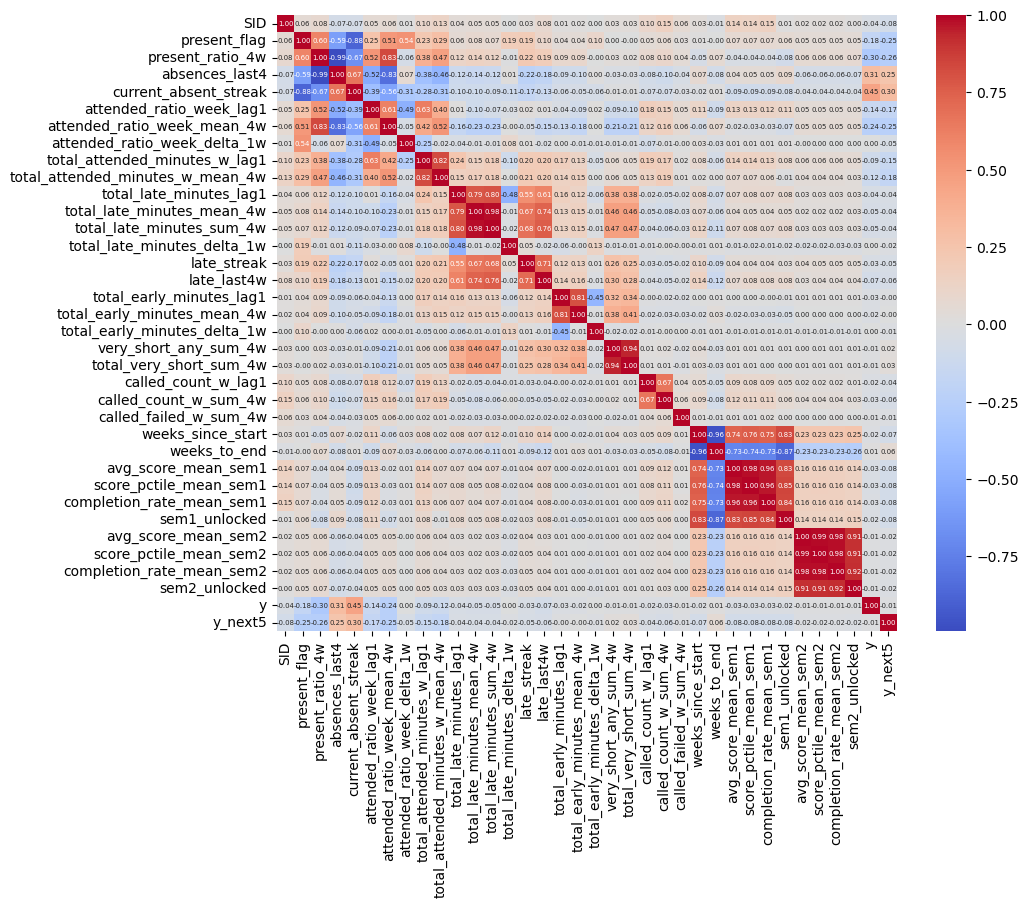

In [76]:
corr = df.drop(columns='week_start').corr()

plt.figure(figsize=(10,8))
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt='.2f', annot_kws={'size':5})
plt.show()

In [77]:
#so each student is a separate time-series
#I take 80% of students as training, the remaining 20% is testing
df['week_start'] = pd.to_datetime(df['week_start'], errors='coerce')
sids = df['SID'].drop_duplicates()
sid_train, sid_test = train_test_split(sids, test_size=0.2, random_state=42)

df_train = df[df['SID'].isin(sid_train)].copy()
df_test = df[df['SID'].isin(sid_test)].copy()

X_train = df_train.drop(columns=['y', 'y_next5', 'SID', 'week_start'])
y_train = df_train['y_next5']
X_test = df_test.drop(columns=['y', 'y_next5', 'SID', 'week_start'])
y_test = df_test['y_next5']

print(df_train["y_next5"].value_counts(normalize=True))
print(df_test["y_next5"].value_counts(normalize=True))

y_next5
0    0.979552
1    0.020448
Name: proportion, dtype: float64
y_next5
0    0.978883
1    0.021117
Name: proportion, dtype: float64


In [78]:
#Scale data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

## Modelling
Simple model with all variables intact (for now)

In [ ]:
pos = (y_train==1).sum(); neg = (y_train==0).sum()
spw = neg / max(1, pos)

xgb = XGBClassifier(
    n_estimators=800,
    learning_rate=0.02,
    max_depth=5,
    subsample=0.8,
    colsample_bytree=0.8,
    objective="binary:logistic",
    scale_pos_weight=spw,
    eval_metric="auc"
).fit(X_train_scaled, y_train)

p = xgb.predict_proba(X_test_scaled)[:, 1]  # <- keep consistent with training

# F_beta selection
beta = 1.5  # >1 favors recall, <1 favors precision. 

prec, rec, thr = precision_recall_curve(y_test, p)
prec_t = prec[:-1]
rec_t  = rec[:-1]

f_beta = (1 + beta**2) * (prec_t * rec_t) / (beta**2 * prec_t + rec_t + 1e-12)
best_ix = int(np.nanargmax(f_beta)) if f_beta.size else 0
best_thr = float(thr[best_ix]) if best_ix < len(thr) else 0.5

y_hat = (p >= best_thr).astype(int)

#metrics
acc  = accuracy_score(y_test, y_hat)
pr   = precision_score(y_test, y_hat, zero_division=0)
rc   = recall_score(y_test, y_hat, zero_division=0)
f1b  = f1_score(y_test, y_hat, zero_division=0)
cm   = confusion_matrix(y_test, y_hat)
pr_auc  = average_precision_score(y_test, p)
roc_auc = roc_auc_score(y_test, p)

k = max(1, int(0.05 * len(p)))
idx = np.argsort(-p)[:k]
p_at_5 = y_test.iloc[idx].mean() #proportion of true dropouts within the top 5% predicted high risk students

print(f"beta = {beta:.2f}. Chosen threshold: {best_thr:.4f}")
print(f"Accuracy : {acc:.3f}")
print(f"Precision: {pr:.3f}")
print(f"Recall   : {rc:.3f}")
print(f"F1-score : {f1b:.3f}")
print(f"PR-AUC   : {pr_auc:.3f}")
print(f"ROC-AUC  : {roc_auc:.3f}")
print("Confusion matrix [[TN, FP],[FN, TP]]:")
print(cm)
print(f"Precision@5% (top-k): {p_at_5:.3f}")

beta = 1.50. Chosen threshold: 0.8260
Accuracy : 0.976
Precision: 0.441
Recall   : 0.564
F1-score : 0.495
PR-AUC   : 0.470
ROC-AUC  : 0.927
Confusion matrix [[TN, FP],[FN, TP]]:
[[9630  151]
 [  92  119]]
Precision@5% (top-k): 0.287


In [86]:
# base rate over weeks
r = y_test.mean()  # share of positive weeks

# top-K (e.g., 5% of all weeks)
K_frac = 0.05
k = max(1, int(K_frac * len(p)))
idx = np.argsort(-p)[:k]
precision_at_k = y_test.iloc[idx].mean()
lift_at_k = precision_at_k / max(1e-12, r)

print(f"Base rate r (per-week): {r:.4f}")
print(f"Precision@{int(K_frac*100)}%: {precision_at_k:.4f}")
print(f"Lift@{int(K_frac*100)}%: {lift_at_k:.1f}x")



Base rate r (per-week): 0.0211
Precision@5%: 0.2866
Lift@5%: 13.6x
